In [78]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import datetime
import skextremes as ske
! pip install openpyxl

     |████████████████████████████████| 242 kB 914 kB/s eta 0:00:01
  Using cached et_xmlfile-1.0.1.tar.gz (8.4 kB)
  Using cached jdcal-1.4.1-py2.py3-none-any.whl (9.5 kB)
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8917 sha256=1b487c66222b083ecbc9878b565d12657465ea459d1fba330c9e1d82bdf47b9a
  Stored in directory: /Users/simon/Library/Caches/pip/wheels/6e/df/38/abda47b884e3e25f9f9b6430e5ce44c47670758a50c0c51759
Successfully built et-xmlfile


In [6]:
flow60 = pd.read_excel('../data/Shipston Wiski data - 60 min.xlsx', 
                        sheet_name = 1)
flow60_filtered = flow60.replace(" ---", np.nan)
flow60_filtered['Flow [m³/s]'] = pd.to_numeric(
    flow60_filtered['Flow [m³/s]'], downcast="float")

In [7]:
stage60 = pd.read_excel('../data/Shipston Wiski data - 60 min.xlsx', 
                          sheet_name = 2)
stage60_filtered = stage60.replace(" ---", np.nan)
stage60_filtered['Stage [m]'] = pd.to_numeric(
    stage60_filtered['Stage [m]'], downcast="float")

In [8]:
rainfall60 = pd.read_excel('../data/Shipston Wiski data - 60 min.xlsx', 
                           sheet_name=3)
rainfall60_filtered = rainfall60.replace(
    " ---", np.nan).replace(".", np.nan).replace("  ---", np.nan)
rainfall60_filtered['Precipitation [mm]'] = pd.to_numeric(
    rainfall60_filtered['Precipitation [mm]'], downcast="float")

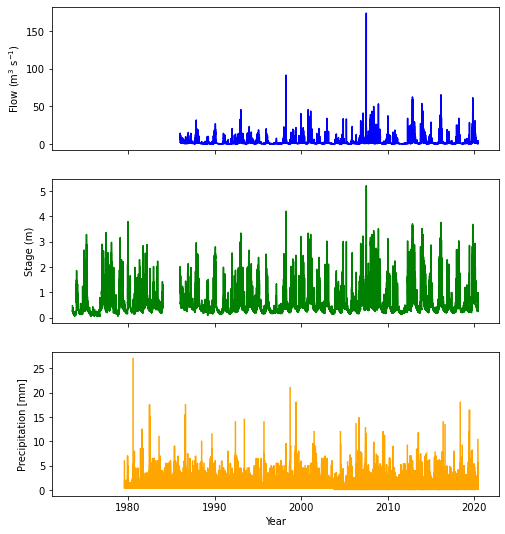

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(8, 3*3), sharex=True)
axes[0].plot(flow60_filtered['Date'], flow60_filtered['Flow [m³/s]'], 'blue')
axes[0].set_ylabel("Flow (m$^3$ s$^{-1}$)")
axes[1].plot(stage60_filtered['Date'], stage60_filtered['Stage [m]'], 'green')
axes[1].set_ylabel("Stage (m)")
axes[2].plot(rainfall60_filtered['Date'], rainfall60_filtered['Precipitation [mm]'], 'orange')
axes[2].set_ylabel('Precipitation [mm]')
axes[2].set_xlabel('Year')
plt.savefig('../report/figures/wiski_60min_lineplots.png', dpi=600, bbox_inches='tight')
plt.savefig('../report/figures/wiski_60min_lineplots.pdf', bbox_inches='tight')

In [84]:
def datetime_transform(dataframe):
    
    date_time = []
    for i in range(len(dataframe['Time'])):
        
        time = dataframe['Time'][i]
        date = datetime.datetime.utcfromtimestamp(
            dataframe['Date'].to_numpy()[i].tolist()/1e9).date()
        date_time.append(datetime.datetime.combine(date, time))
        
    dataframe = dataframe.assign(datetime = date_time)    
    return dataframe
    

def take_block_maxima(dataframe, key):
    
    dataframe = datetime_transform(dataframe)
    dataframe = dataframe.set_index('datetime')

    max_df = dataframe.groupby(lambda x: x.year)[key].agg(['mean', 'max'])
    
    return max_df


def peak_over_threshold(dataframe, key, threshold):
    
    dataframe = datetime_transform(dataframe)
    npa = dataframe[key].to_numpy()
    dates = dataframe['datetime'].to_numpy()
    
    where_are_NaNs = np.isnan(npa)
    npa[where_are_NaNs] = 0
    x = npa
    peaks, _ = find_peaks(x, height=threshold)
    plt.plot(dates, x)
    plt.plot(dates[peaks], x[peaks], "x")
    #plt.plot(np.zeros_like(x), "--", color="gray")
    plt.ylabel(key)
    plt.savefig('../report/figures/'+key+'.png', bbox_inches='tight')
    plt.show()
    flood_dates = dates[peaks]
    flood_heights = x[peaks]
    
    #for i in range(len(peaks)):
    #    print(flood_dates[i], flood_heights[i]
    
    return pd.DataFrame(data={'datetime': flood_dates, 
                              'heights': flood_heights})

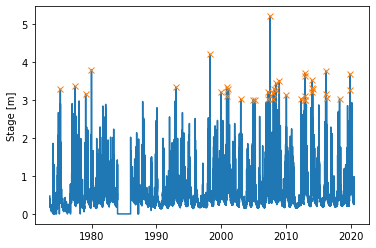

In [86]:
# max_rainfall60 = take_block_maxima(rainfall60_filtered, 'Precipitation [mm]')
#max_stage60 = take_block_maxima(stage60_filtered, 'Stage [m]')
#max_flow60 = take_block_maxima(flow60_filtered, 'Flow [m³/s]')
pot_stage60 = peak_over_threshold(stage60_filtered, 'Stage [m]', 3)
# pot_flow60 = peak_over_threshold(flow60_filtered, 'Flow [m³/s]', 20)

In [79]:
pot_stage60.to_excel('../data/Stage60_3m_threshold.xlsx')

In [29]:

def extremes(max_npa):
    model = ske.models.classic.GEV(max_npa,
                                   ev_unit=' $\;$(m)',
                                   block_unit='(Yrs)',
                                   fit_method='mle',
                                   ci=0.05,
                                   ci_method='delta',
                                   # ci_method='bootstrap'
                                   )

    print(model.params)
    print(model.params_ci)

    model.plot_summary()
    fig = plt.gcf()

    try:
        mu_string = r"{0:.2f}$\pm${1:.2f}".format(model.params['location'],
                                                  np.abs((model.params['location']
                                                          - model.params_ci['location'][1])/2))
        sigma_string = r"{0:.2f}$\pm${1:.2f}".format(model.params['scale'],
                                                     np.abs((model.params['scale']
                                                            - model.params_ci['scale'][1])/2))
        xi_string = r"{0:.2f}$\pm${1:.2f}".format(model.params['shape'],
                                                  np.abs((model.params['shape']
                                                  - model.params_ci['shape'][1])/2))

    except:
        print('Confidence itervals not available')
        mu_string = r"{0:.2f} ".format(model.params['location'])
        sigma_string = r"{0:.2f} ".format(model.params['scale'])
        xi_string = r"{0:.2f}".format(model.params['shape'])

    fig.suptitle(r'$\quad$ $\mu=$' + mu_string
                 + r'm, $\sigma=$' + sigma_string
                 + r'm, $\xi=$' + xi_string,
                 y=1.03, fontsize=10)

    #mps.defined_size(fig, size='dcm')
    plt.tight_layout()
    axs = fig.axes
    #mps.label_subplots(axs)
    #mps.save_fig_twice(cfg.plots_loc + 'GEV_model' + initials[i])
    # plt.show()
    plt.savefig('../report/figures/bm-fit.png', bbox_inches='tight')
    # plt.show()


/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:657: RuntimeWarning: divide by zero encountered in log
  sT = -_np.log(1. - self.frec / T) # ~~return period
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:657: RuntimeWarning: invalid value encountered in log
  sT = -_np.log(1. - self.frec / T) # ~~return period
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:628: RuntimeWarning: invalid value encountered in log
  (1. + 1. / c) * _np.sum(_np.log(expr)) +
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:629: RuntimeWarning: invalid value encountered in power
  _np.sum(expr ** ( -1. / c)))
/Users/simon/anaconda3/envs/shipston-ext/lib/python3.8/site-packages/skextremes/models/classic.py:627: RuntimeWarning: invalid value encountered in log
  return (len(x) * _np.log(scale) +
/Users/simon/anacon


 c is  -0.6680169350764469 


 !working out GEV confidence intervals! 

OrderedDict([('shape', 0.6680169350764469), ('location', 2.6340915571865824), ('scale', 1.7300270898113408)])
OrderedDict([('shape', (nan, nan)), ('location', (nan, nan)), ('scale', (nan, nan))])


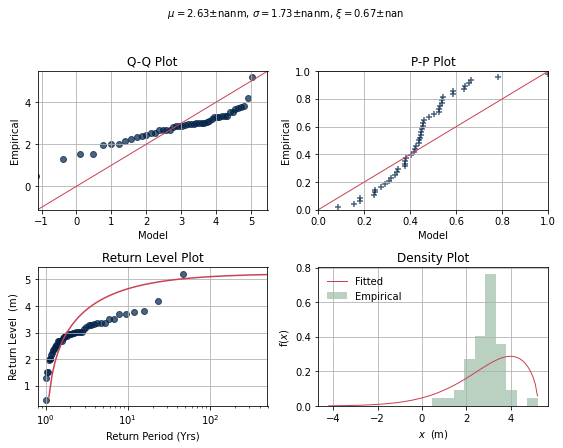

In [30]:
np_max = max_stage60['max'].to_numpy()
extremes(np_max[~np.isnan(np_max)])

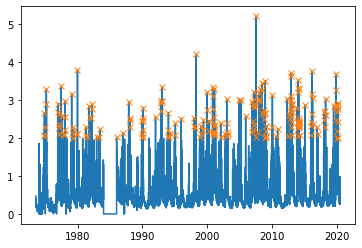

1974-11-14T00:00:00.000000000 2.076
1974-11-18T00:00:00.000000000 2.042
1974-11-21T00:00:00.000000000 2.673
1975-01-20T00:00:00.000000000 2.288
1975-03-09T00:00:00.000000000 3.287
1975-03-14T00:00:00.000000000 2.902
1976-12-19T00:00:00.000000000 2.683
1977-01-01T00:00:00.000000000 2.907
1977-02-10T00:00:00.000000000 2.298
1977-02-20T00:00:00.000000000 2.367
1977-02-22T00:00:00.000000000 2.099
1977-02-24T00:00:00.000000000 2.645
1977-06-14T00:00:00.000000000 3.362
1977-08-25T00:00:00.000000000 2.575
1977-12-10T00:00:00.000000000 2.097
1977-12-11T00:00:00.000000000 2.086
1978-01-23T00:00:00.000000000 2.568
1978-01-28T00:00:00.000000000 2.978
1978-02-04T00:00:00.000000000 2.213
1979-02-02T00:00:00.000000000 3.166
1979-03-26T00:00:00.000000000 2.008
1979-03-28T00:00:00.000000000 2.097
1979-03-29T00:00:00.000000000 2.291
1979-05-31T00:00:00.000000000 2.216
1979-12-11T00:00:00.000000000 2.1
1979-12-14T00:00:00.000000000 2.099
1979-12-27T00:00:00.000000000 3.796
1981-04-27T00:00:00.000000000 

In [51]:
return_peaks(stage60_filtered["Stage [m]"].to_numpy(), stage60_filtered["Date"].to_numpy())